In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
df_list = pd.read_csv('../input/seattle/listings.csv')
df_cal = pd.read_csv('../input/seattle/calendar.csv')
df_rev = pd.read_csv('../input/seattle/reviews.csv')

In [3]:
def dollar_float(x):
    '''
    input: dollar value with string dtype
    output: value in float
    '''
    if type(x)==str:
        x=x[1:].replace(",","")
        x=float(x)
    return x

def perc_float(x):
    '''
    input: % value with string dtype
    output: % value in float
    '''
    if type(x)==str:
        x=x.replace('%','')
        x=float(x)/100.0
    return (x)

In [4]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [5]:
df_cal.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
df_cal.dropna(subset=['price'],inplace=True)

df_cal['price']=df_cal['price'].apply(lambda x: dollar_float(x))

df_cal['date'] = pd.to_datetime(df_cal['date'],format="%Y-%m-%d")
df_cal['year'] = df_cal['date'].dt.year
df_cal['month'] = df_cal['date'].dt.month
df_cal['day'] = df_cal['date'].dt.day
df_cal['day_name'] = df_cal['date'].dt.day_name()
df_cal['day_num'] = df_cal['date'].dt.weekday

df_cal['available'] = df_cal['available'].apply(lambda x:1 if x =='t' else 0)

df_cal.head()

,listing_id,date,available,price,year,month,day,day_name,day_num
0,241032,2016-01-04,1,85.0,2016,1,4,Monday,0
1,241032,2016-01-05,1,85.0,2016,1,5,Tuesday,1
9,241032,2016-01-13,1,85.0,2016,1,13,Wednesday,2
10,241032,2016-01-14,1,85.0,2016,1,14,Thursday,3
14,241032,2016-01-18,1,85.0,2016,1,18,Monday,0


In [7]:
df_cal.describe()

,listing_id,available,price,year,month,day,day_num
count,9.345420e+05,934542.0,934542.000000,934542.000000,934542.000000,934542.00000,934542.000000
mean,5.305517e+06,1.0,137.944859,2016.006097,6.661120,15.87560,2.990591
std,2.974821e+06,0.0,105.062870,0.077846,3.446401,8.81395,2.004433
min,3.335000e+03,1.0,10.000000,2016.000000,1.000000,1.00000,0.000000
25%,2.875975e+06,1.0,75.000000,2016.000000,4.000000,8.00000,1.000000
50%,5.615620e+06,1.0,109.000000,2016.000000,7.000000,16.00000,3.000000
75%,7.873345e+06,1.0,160.000000,2016.000000,10.000000,24.00000,5.000000
max,1.034016e+07,1.0,1650.000000,2017.000000,12.000000,31.00000,6.000000


In [8]:
df_cal[df_cal.year==2017].groupby('month').available.sum()

month
1    5698
Name: available, dtype: int64

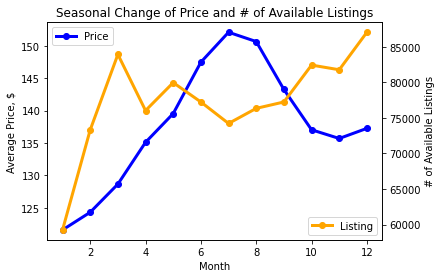

In [9]:
fig,ax = plt.subplots()
ax.plot(df_cal[df_cal.year==2016].groupby(['month']).price.mean(),color='blue', marker='o', linewidth=3, label='Price')
ax.set_xlabel('Month')
ax.set_ylabel('Average Price, $')

ax2 = ax.twinx()
ax2.plot(df_cal[df_cal.year==2016].groupby(['month']).available.sum(), color='orange', marker ='o', linewidth=3, label='Listing')
ax2.set_ylabel('# of Available Listings')

ax.legend(loc=2)
ax2.legend(loc=4)

plt.title('Seasonal Change of Price and # of Available Listings')
plt.show()

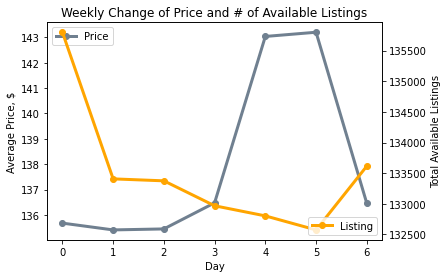

In [10]:
fig,ax = plt.subplots()
ax.plot(df_cal.groupby(['day_num']).price.mean(),color='slategrey', marker='o', linewidth=3, label='Price')
ax.set_xlabel('Day')
ax.set_ylabel('Average Price, $')

ax2 = ax.twinx()
ax2.plot(df_cal.groupby(['day_num']).available.sum(), color='orange', marker ='o', linewidth=3, label="Listing")
ax2.set_ylabel('Total Available Listings')

ax.legend(loc=2)
ax2.legend(loc=4)

plt.title('Weekly Change of Price and # of Available Listings')
plt.show()

In [11]:
df_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [12]:
df_list.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [13]:
df_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [14]:
df_list.dropna(subset=['price'],inplace=True)
df_list['price'] = df_list['price'].apply(lambda x:dollar_float(x))
df_list['monthly_price'] = df_list['monthly_price'].apply(lambda x:dollar_float(x))
df_list['weekly_price'] = df_list['weekly_price'].apply(lambda x:dollar_float(x))
df_list['security_deposit'] = df_list['security_deposit'].apply(lambda x:dollar_float(x))
df_list['cleaning_fee'] = df_list['cleaning_fee'].apply(lambda x:dollar_float(x))
df_list['extra_people'] = df_list['extra_people'].apply(lambda x:dollar_float(x))

df_list['host_response_rate'] = df_list['host_response_rate'].apply(lambda x:perc_float(x))
df_list['host_since'] = (pd.to_datetime('2017-02-01') - pd.to_datetime(df_list['host_since'])) / np.timedelta64(1, 'D')

df_list['last_scraped'] = (pd.to_datetime('2017-02-01') - pd.to_datetime(df_list['last_scraped'])) / np.timedelta64(1, 'D')
df_list['first_review'] = (pd.to_datetime('2017-02-01') - pd.to_datetime(df_list['first_review'])) / np.timedelta64(1, 'D')
df_list['last_review'] = (pd.to_datetime('2017-02-01') - pd.to_datetime(df_list['last_review'])) / np.timedelta64(1, 'D')

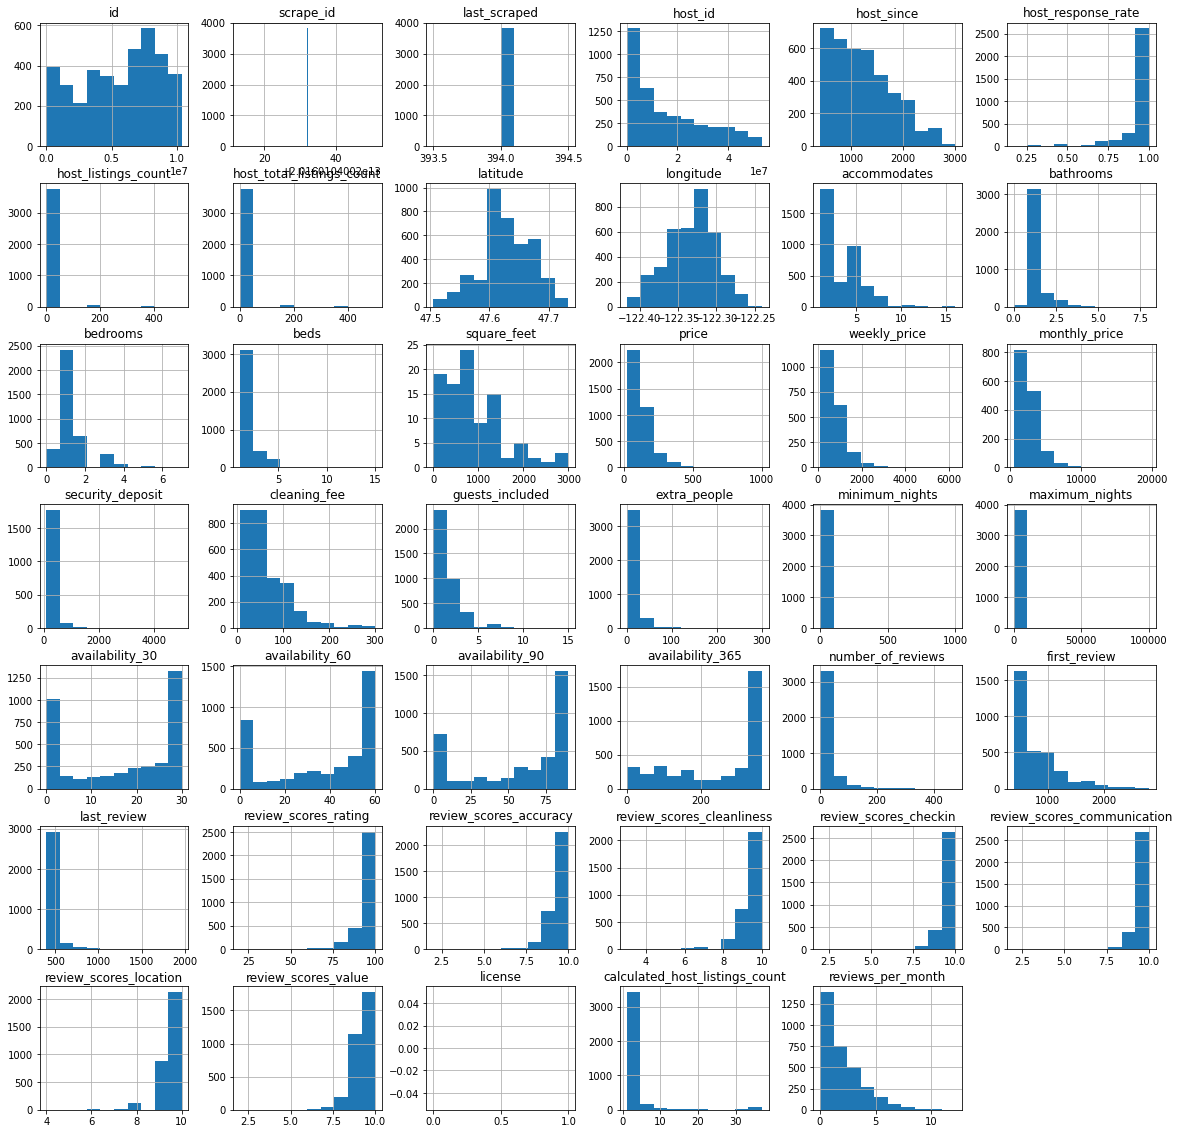

In [15]:
df_list.hist(figsize=(20,20))
plt.show()

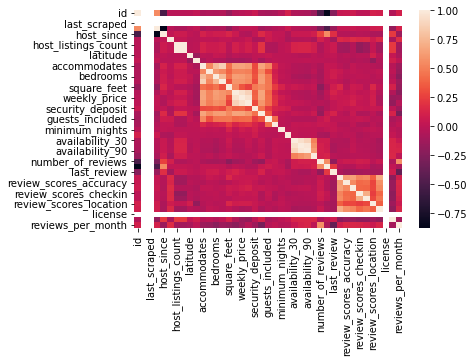

In [16]:
sns.heatmap(df_list.corr())
plt.show()

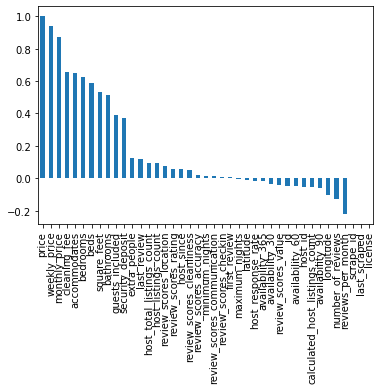

In [17]:
df_list.corr()['price'].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=90)
plt.show()

In [18]:
df_list.corr()["reviews_per_month"].sort_values

<bound method Series.sort_values of id                                0.091716
scrape_id                              NaN
last_scraped                           NaN
host_id                           0.106389
host_since                       -0.142958
host_response_rate                0.171140
host_listings_count              -0.117272
host_total_listings_count        -0.117272
latitude                         -0.084988
longitude                         0.002583
accommodates                     -0.144150
bathrooms                        -0.167894
bedrooms                         -0.230287
beds                             -0.149079
square_feet                      -0.176298
price                            -0.218588
weekly_price                     -0.131621
monthly_price                    -0.030253
security_deposit                 -0.140299
cleaning_fee                     -0.303313
guests_included                  -0.028903
extra_people                      0.004094
minimum_nights    

In [19]:
df_list.amenities.head()

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object

In [20]:
all_ame = []
for x in df_list.amenities:
    all_ame.extend(x.replace('{','').replace('}','').replace('"','').split(','))
unique_ame = pd.unique(all_ame)
unique_ame

array(['TV', 'Cable TV', 'Internet', 'Wireless Internet',
       'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly',
       'Washer', 'Dryer', 'Free Parking on Premises',
       'Buzzer/Wireless Intercom', 'Smoke Detector',
       'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card',
       'Fire Extinguisher', 'Essentials', 'Pets Allowed',
       'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub',
       'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in',
       'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace',
       'Suitable for Events', 'Elevator in Building',
       'Lock on Bedroom Door', 'Wheelchair Accessible', 'Gym', '', 'Pool',
       'Smoking Allowed', 'Other pet(s)', 'Doorman', 'Washer / Dryer'],
      dtype=object)

In [21]:
zero_matrix = np.zeros((len(df_list),len(unique_ame)))
dummies_ame = pd.DataFrame(zero_matrix,columns=unique_ame)
for i,ame in enumerate(df_list.amenities):
    indices = dummies_ame.columns.get_indexer(ame.replace('{','').replace('}','').replace('"','').split(','))
    dummies_ame.iloc[i,indices]=1
dummies_ame

,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,Dryer,...,Elevator in Building,Lock on Bedroom Door,Wheelchair Accessible,Gym,,Pool,Smoking Allowed,Other pet(s),Doorman,Washer / Dryer
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3814,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3815,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

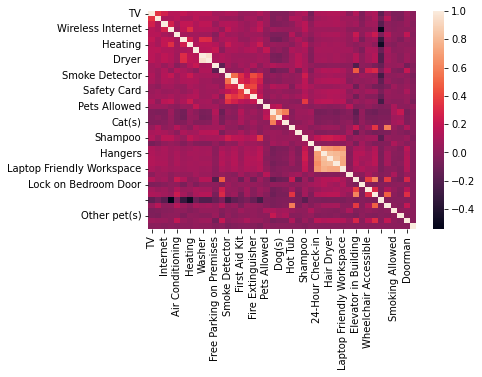

In [22]:
sns.heatmap(dummies_ame.corr())

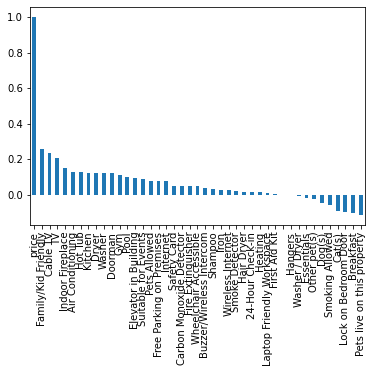

In [23]:
df_list_ame_price = pd.concat([df_list['price'],dummies_ame],axis=1)
df_list_ame_price.corr()['price'].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=90)
plt.show()

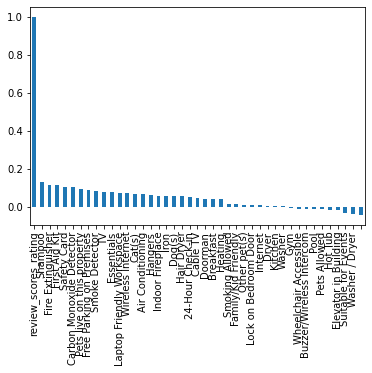

In [24]:
df_list_ame_review = pd.concat([df_list['review_scores_rating'],dummies_ame],axis=1)
df_list_ame_review.corr()['review_scores_rating'].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=90)
plt.show()

In [25]:
df_list.host_verifications.head

<bound method NDFrame.head of 0                    ['email', 'phone', 'reviews', 'kba']
1       ['email', 'phone', 'facebook', 'linkedin', 're...
2        ['email', 'phone', 'google', 'reviews', 'jumio']
3       ['email', 'phone', 'facebook', 'reviews', 'jum...
4        ['email', 'phone', 'facebook', 'reviews', 'kba']
                              ...                        
3813    ['email', 'phone', 'linkedin', 'reviews', 'jum...
3814    ['email', 'phone', 'facebook', 'reviews', 'jum...
3815                                            ['phone']
3816     ['email', 'phone', 'facebook', 'reviews', 'kba']
3817                 ['email', 'phone', 'reviews', 'kba']
Name: host_verifications, Length: 3818, dtype: object>

In [26]:
all_h_ver = []
for x in df_list.host_verifications:
    all_h_ver.extend(x.replace('[','').replace(']','').replace("'",'').replace(" ","").split(','))
unique_h_ver = pd.unique(all_h_ver)
unique_h_ver

array(['email', 'phone', 'reviews', 'kba', 'facebook', 'linkedin',
       'jumio', 'google', 'manual_offline', 'amex', 'manual_online',
       'sent_id', 'photographer', '', 'None', 'weibo'], dtype=object)

In [27]:
zero_matrix = np.zeros((len(df_list),len(unique_h_ver)))
dummies_h_ver = pd.DataFrame(zero_matrix,columns=unique_h_ver)
for i,ver in enumerate(df_list.host_verifications):
    indices = dummies_h_ver.columns.get_indexer(ver.replace('[','').replace(']','').replace("'",'').replace(" ","").split(','))
    dummies_h_ver.iloc[i,indices]=1
dummies_h_ver

,email,phone,reviews,kba,facebook,linkedin,jumio,google,manual_offline,amex,manual_online,sent_id,photographer,,None,weibo
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3814,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3815,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

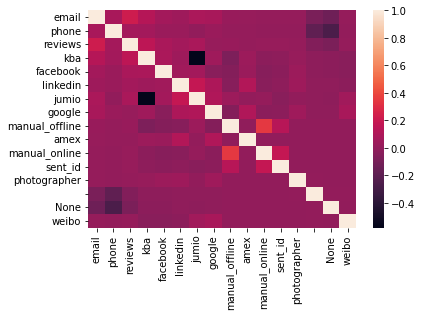

In [28]:
sns.heatmap(dummies_h_ver.corr())

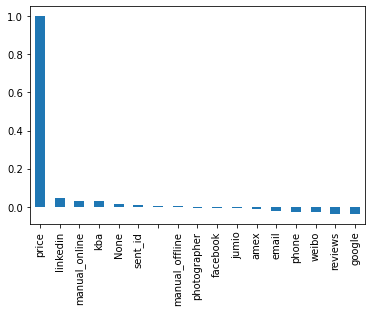

In [29]:
df_list_ver_price = pd.concat([df_list['price'],dummies_h_ver],axis=1)
df_list_ver_price.corr()['price'].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=90)
plt.show()

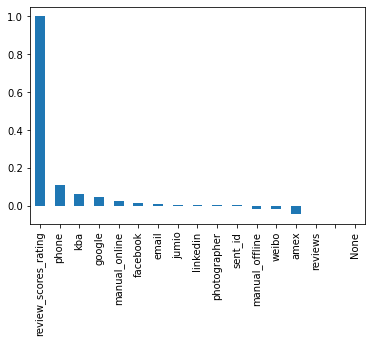

In [30]:
df_list_ver_review = pd.concat([df_list['review_scores_rating'],dummies_h_ver],axis=1)
df_list_ver_review.corr()['review_scores_rating'].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=90)
plt.show()

In [31]:
df_list_cat = df_list.select_dtypes(include=['object'])
df_list_cat.nunique().sort_values(ascending=False)

listing_url                         3818
picture_url                         3818
name                                3792
description                         3742
medium_url                          3498
xl_picture_url                      3498
thumbnail_url                       3498
summary                             3478
amenities                           3284
space                               3119
host_url                            2751
host_thumbnail_url                  2743
host_picture_url                    2743
transit                             2574
neighborhood_overview               2506
host_about                          2011
notes                               1999
host_name                           1466
street                              1442
host_location                        120
host_verifications                   116
host_neighbourhood                   102
neighbourhood_cleansed                87
neighbourhood                         81
calendar_updated

In [32]:
col_address = ['street','host_location', 'host_neighbourhood', 'neighbourhood_cleansed', 'neighbourhood', 
         'neighbourhood_group_cleansed','zipcode', 'city','state']
df_list[col_address].describe()

,street,host_location,host_neighbourhood,neighbourhood_cleansed,neighbourhood,neighbourhood_group_cleansed,zipcode,city,state
count,3818,3810,3518,3818,3402,3818,3811,3818,3818
unique,1442,120,102,87,81,17,28,7,2
top,"1st Avenue, Seattle, WA 98101, United States","Seattle, Washington, United States",Capitol Hill,Broadway,Capitol Hill,Other neighborhoods,98122,Seattle,WA
freq,30,3259,405,397,351,794,420,3810,3817


In [33]:
for col in col_address:
    if col == 'street':
        continue
    elif col == 'host_location':
        continue
    else:
        print(df_list[col].value_counts())

Capitol Hill          405
Belltown              254
Ballard               210
Minor                 191
Queen Anne            189
                     ... 
Northwest District      1
Beverly Hills           1
Long Beach              1
Baldwin Hills           1
East Village            1
Name: host_neighbourhood, Length: 102, dtype: int64
Broadway             397
Belltown             234
Wallingford          167
Fremont              158
Minor                135
                    ... 
Arbor Heights          5
Pinehurst              4
South Beacon Hill      4
South Park             3
Roxhill                2
Name: neighbourhood_cleansed, Length: 87, dtype: int64
Capitol Hill          351
Ballard               213
Belltown              204
Minor                 192
Queen Anne            187
                     ... 
Pike Market             2
South Park              2
North College Park      1
Fairmount Park          1
Roxhill                 1
Name: neighbourhood, Length: 81, dtype: int64


In [34]:
col_cat = ['neighbourhood_group_cleansed','property_type','calendar_updated',
          'smart_location','bed_type','host_response_time','cancellation_policy','room_type',
           'instant_bookable','is_location_exact','require_guest_profile_picture','host_identity_verified',
           'host_has_profile_pic','host_is_superhost','host_acceptance_rate','require_guest_phone_verification']

In [35]:
dummies_cat = pd.get_dummies(df_list[col_cat],prefix_sep='_',drop_first=True, dummy_na=False)
dummies_cat.shape

(3818, 89)

In [36]:
df_cat_price = df_list['price']
df_cat_price = pd.concat([df_cat_price, dummies_cat],axis=1)
df_cat_price.corr()['price'].sort_values(ascending=False)[df_cat_price.corr()['price'].sort_values()>0].head(11)

price                                      1.000000
cancellation_policy_strict                 0.226632
calendar_updated_13 months ago             0.145122
bed_type_Real Bed                          0.126372
neighbourhood_group_cleansed_Downtown      0.117590
neighbourhood_group_cleansed_Queen Anne    0.093789
calendar_updated_today                     0.086081
property_type_Boat                         0.078404
neighbourhood_group_cleansed_Magnolia      0.070174
require_guest_profile_picture_t            0.063297
calendar_updated_5 months ago              0.060952
Name: price, dtype: float64

In [37]:
df_cat_price.corr()['price'].sort_values()[df_cat_price.corr()['price'].sort_values()<0].head(10)

room_type_Private room                             -0.387502
room_type_Shared room                              -0.158473
host_acceptance_rate_100%                          -0.130585
host_response_time_within an hour                  -0.114852
cancellation_policy_moderate                       -0.102123
bed_type_Futon                                     -0.085925
neighbourhood_group_cleansed_Rainier Valley        -0.083340
neighbourhood_group_cleansed_Delridge              -0.072000
neighbourhood_group_cleansed_University District   -0.069133
neighbourhood_group_cleansed_Beacon Hill           -0.065915
Name: price, dtype: float64

(0.0, 400.0)

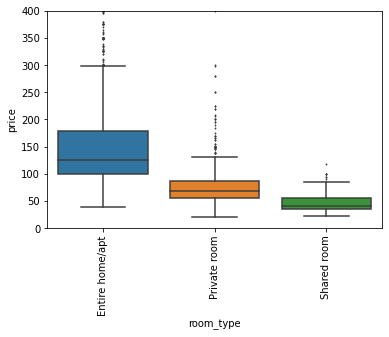

In [38]:
ax = sns.boxplot(data=df_list, x='room_type',y='price',fliersize=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0, 400)

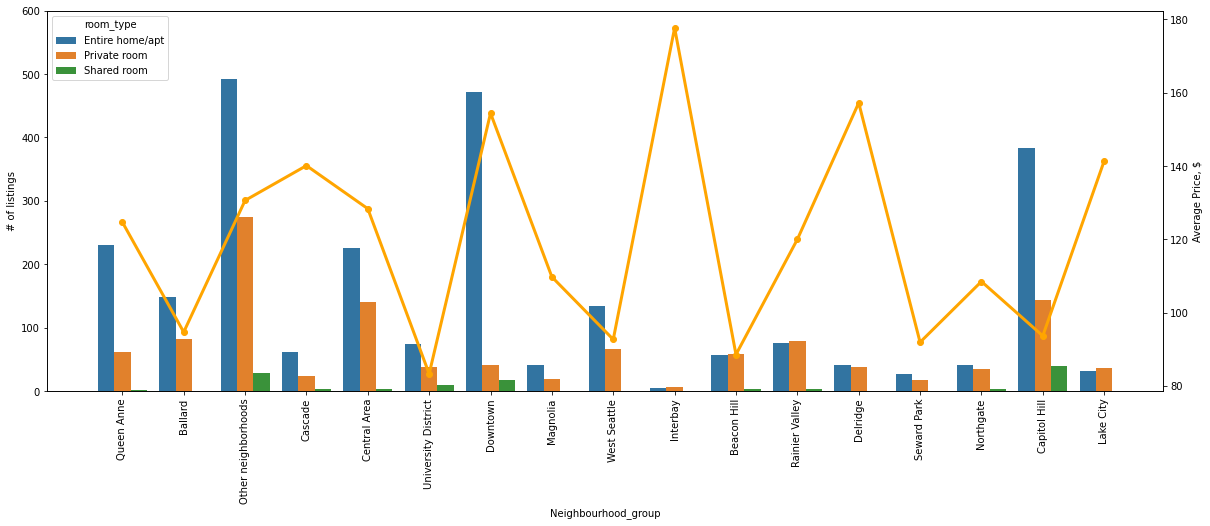

In [39]:
plt.figure(figsize=(20,7))
ax = sns.countplot(data=df_list, x='neighbourhood_group_cleansed',hue='room_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Neighbourhood_group')
ax.set_ylabel('# of listings')

ax2 = ax.twinx()
ax2.plot(df_list.groupby(['neighbourhood_group_cleansed'])['price'].mean(), color='orange', marker ='o', linewidth=3, label='Listing')
ax2.set_ylabel('Average Price, $')

ax.set_ylim(0, 600)
plt.show()

(0.0, 400.0)

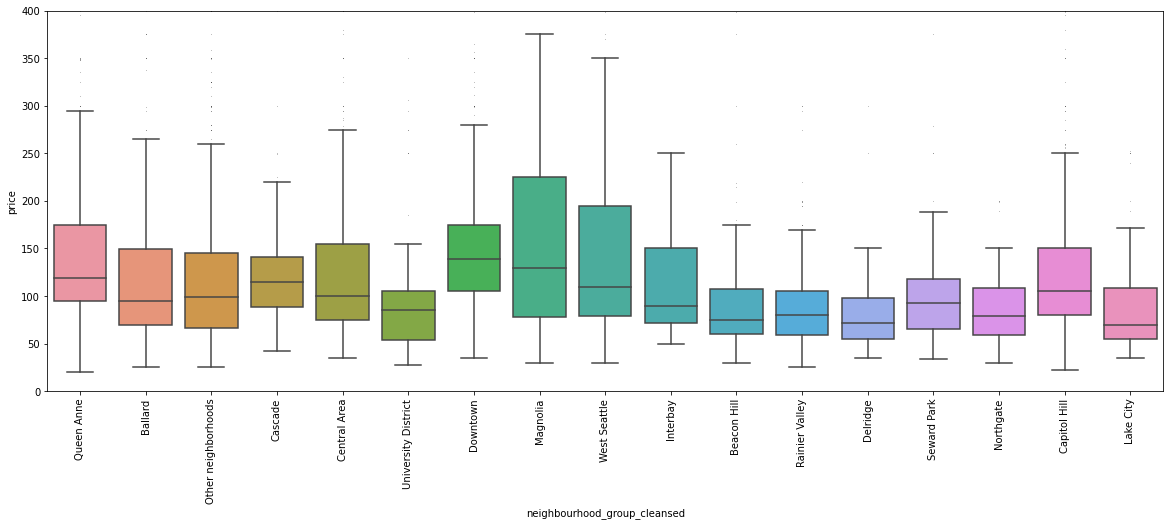

In [40]:
plt.figure(figsize=(20,7))
ax = sns.boxplot(data=df_list, x='neighbourhood_group_cleansed',y='price',fliersize=0.1,)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0, 400)

<AxesSubplot:title={'center':'Missing values per column'}>

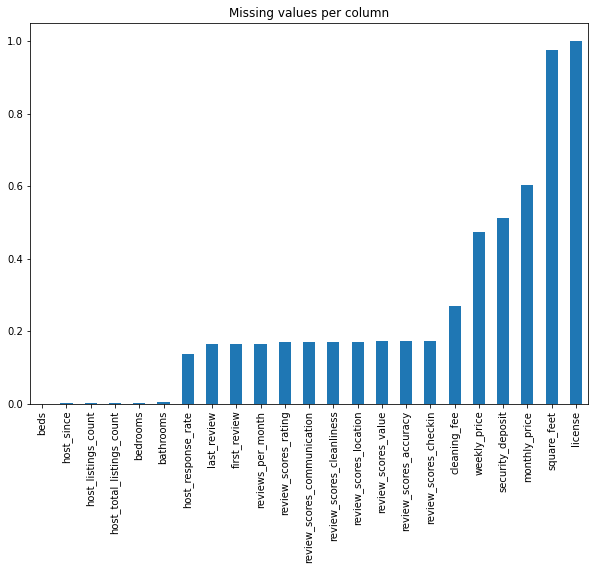

In [41]:
plt.figure(figsize=(10,7))
df_list_missing = df_list.select_dtypes(include=['number']).isnull().mean()
df_list_missing[df_list_missing >0].sort_values().plot.bar(title='Missing values per column')

In [42]:
df_list.security_deposit.describe()

count    1866.000000
mean      287.610397
std       270.222690
min        95.000000
25%       150.000000
50%       250.000000
75%       300.000000
max      5000.000000
Name: security_deposit, dtype: float64

In [43]:
df_list.cleaning_fee.describe()

count    2788.000000
mean       61.710904
std        48.830341
min         5.000000
25%        25.000000
50%        50.000000
75%        83.000000
max       300.000000
Name: cleaning_fee, dtype: float64

In [44]:
df_list[df_list.security_deposit.isnull()==True].price.mean()

113.50665983606558

In [45]:
df_list[df_list.security_deposit.isnull()==False].price.mean()

143.11254019292605

In [46]:
df_list[df_list.cleaning_fee.isnull()==True].price.mean()

103.94368932038834

In [47]:
df_list[df_list.cleaning_fee.isnull()==False].price.mean()

136.85473457675752

In [48]:
df_security_deposit = pd.qcut(df_list['security_deposit'], q=10, duplicates='drop')
df_cleaning_fee = pd.qcut(df_list['cleaning_fee'], q=10, duplicates='drop')
df_security_deposit = pd.get_dummies(df_security_deposit,prefix='security_deposit',drop_first=True, dummy_na=True)
df_cleaning_fee = pd.get_dummies(df_cleaning_fee,prefix='cleaning_fee',drop_first=True, dummy_na=True)

In [49]:
df_num = df_list.select_dtypes(include=['number'])
df_num = df_num.drop(['scrape_id','host_id','security_deposit', 'cleaning_fee','monthly_price','weekly_price','square_feet','license'],axis=1)
fill_mean = lambda x:x.fillna(x.mean())
df_num = df_num.apply(fill_mean,axis=0)

In [50]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   last_scraped                    3818 non-null   float64
 2   host_since                      3818 non-null   float64
 3   host_response_rate              3818 non-null   float64
 4   host_listings_count             3818 non-null   float64
 5   host_total_listings_count       3818 non-null   float64
 6   latitude                        3818 non-null   float64
 7   longitude                       3818 non-null   float64
 8   accommodates                    3818 non-null   int64  
 9   bathrooms                       3818 non-null   float64
 10  bedrooms                        3818 non-null   float64
 11  beds                            3818 non-null   float64
 12  price                           38

In [51]:
col_drop = ['id','last_scraped','host_response_rate','host_since','host_listings_count','host_total_listings_count',
            'number_of_reviews','first_review','last_review','review_scores_rating',
           'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value',
           'calculated_host_listings_count','reviews_per_month']
df_num_pred = df_num.drop(col_drop,axis=1)
df_num_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   latitude          3818 non-null   float64
 1   longitude         3818 non-null   float64
 2   accommodates      3818 non-null   int64  
 3   bathrooms         3818 non-null   float64
 4   bedrooms          3818 non-null   float64
 5   beds              3818 non-null   float64
 6   price             3818 non-null   float64
 7   guests_included   3818 non-null   int64  
 8   extra_people      3818 non-null   float64
 9   minimum_nights    3818 non-null   int64  
 10  maximum_nights    3818 non-null   int64  
 11  availability_30   3818 non-null   int64  
 12  availability_60   3818 non-null   int64  
 13  availability_90   3818 non-null   int64  
 14  availability_365  3818 non-null   int64  
dtypes: float64(7), int64(8)
memory usage: 606.3 KB


In [52]:
col_cat_pred = ['neighbourhood_group_cleansed','property_type',
          'bed_type','cancellation_policy','room_type',
           'instant_bookable','require_guest_profile_picture','host_identity_verified',
           'host_has_profile_pic','require_guest_phone_verification']
df_cat_pred = pd.get_dummies(df_list[col_cat_pred],prefix_sep='_',drop_first=True, dummy_na=False)

In [53]:
df_cat_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 44 columns):
 #   Column                                            Non-Null Count  Dtype
---  ------                                            --------------  -----
 0   neighbourhood_group_cleansed_Beacon Hill          3818 non-null   uint8
 1   neighbourhood_group_cleansed_Capitol Hill         3818 non-null   uint8
 2   neighbourhood_group_cleansed_Cascade              3818 non-null   uint8
 3   neighbourhood_group_cleansed_Central Area         3818 non-null   uint8
 4   neighbourhood_group_cleansed_Delridge             3818 non-null   uint8
 5   neighbourhood_group_cleansed_Downtown             3818 non-null   uint8
 6   neighbourhood_group_cleansed_Interbay             3818 non-null   uint8
 7   neighbourhood_group_cleansed_Lake City            3818 non-null   uint8
 8   neighbourhood_group_cleansed_Magnolia             3818 non-null   uint8
 9   neighbourhood_group_cleansed_Northgate   

In [54]:
y = df_num_pred.price

X = df_num_pred.drop('price',axis=1)
X = pd.concat([X,df_security_deposit],axis=1)
X = pd.concat([X,df_cleaning_fee],axis=1)
X = pd.concat([X,dummies_ame],axis=1)
X = pd.concat([X,df_cat_pred],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
X_train.shape

(2672, 118)

Traning Data:
r-sqaured score: 0.612
mean-sqaured error: 3089.897
---
Test Data:
r-sqaured score: 0.619
mean-sqaured error: 3266.677
---


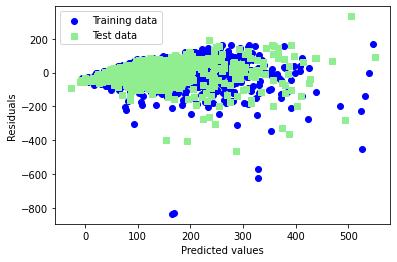

In [55]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train) 

y_test_pred = lr_model.predict(X_test)
y_train_pred = lr_model.predict(X_train)

print('Traning Data:')
print('r-sqaured score: %.3f' % r2_score(y_train, y_train_pred))
print('mean-sqaured error: %.3f' % mean_squared_error(y_train, y_train_pred))
print('---')
print('Test Data:')
print('r-sqaured score: %.3f' % r2_score(y_test, y_test_pred))
print('mean-sqaured error: %.3f' % mean_squared_error(y_test, y_test_pred))
print('---')
    
plt.scatter(y_train_pred,  y_train_pred - y_train,c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()

In [56]:
def coef_weights(coefficients, X):
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X.columns
    coefs_df['coefs'] = lr_model.coef_
    coefs_df = coefs_df.sort_values('coefs', ascending=False)
    return coefs_df

In [57]:
coef_df = coef_weights(lr_model.coef_,X)
coef_df.head(20)

,est_int,coefs
4,bedrooms,23.298416
2,accommodates,15.558720
30,"cleaning_fee_(120.0, 300.0]",13.685276
3,bathrooms,12.685521
79,neighbourhood_group_cleansed_Downtown,8.932170
20,"security_deposit_(500.0, 5000.0]",8.742963
75,neighbourhood_group_cleansed_Capitol Hill,8.470230
31,cleaning_fee_nan,7.660315
85,neighbourhood_group_cleansed_Queen Anne,5.957548
91,property_type_Boat,4.617312


In [58]:
coef_df.sort_values('coefs', ascending=True).head(20)

,est_int,coefs
111,room_type_Private room,-17.714755
112,room_type_Shared room,-13.305808
86,neighbourhood_group_cleansed_Rainier Valley,-5.514957
59,Hangers,-4.234134
0,latitude,-3.255350
78,neighbourhood_group_cleansed_Delridge,-3.205462
11,availability_60,-3.057096
83,neighbourhood_group_cleansed_Northgate,-2.962542
58,24-Hour Check-in,-2.870180
74,neighbourhood_group_cleansed_Beacon Hill,-2.818230


Traning Data:
r-sqaured score: 0.940
mean-sqaured error: 479.089
---
Test Data:
r-sqaured score: 0.605
mean-sqaured error: 3381.481
---


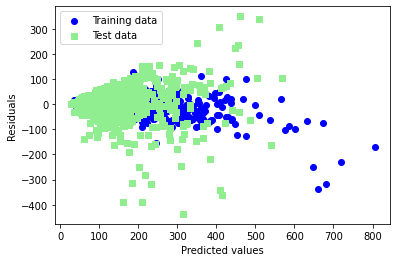

In [59]:
forest = RandomForestRegressor(n_estimators=100,n_jobs=-1)
forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('Traning Data:')
print('r-sqaured score: %.3f' % r2_score(y_train, y_train_pred))
print('mean-sqaured error: %.3f' % mean_squared_error(y_train, y_train_pred))
print('---')
print('Test Data:')
print('r-sqaured score: %.3f' % r2_score(y_test, y_test_pred))
print('mean-sqaured error: %.3f' % mean_squared_error(y_test, y_test_pred))
print('---')
    
plt.scatter(y_train_pred,  y_train_pred - y_train,c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()